### **Downloading the Dataset**

In [ ]:
import kagglehub

path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1


In [ ]:
!pip install --upgrade kagglehub

import kagglehub

! pip install -q silence_tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import warnings
warnings.filterwarnings('ignore')
import os
import time
import random
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tabulate import tabulate
from termcolor import colored
import matplotlib.pyplot as plt
from IPython.display import display
from keras.models import Sequential
from keras import models, layers, optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
sns.set_style('whitegrid')

### **Dataset Inspection**

In [ ]:
dir1 = '/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset'

# This lists the subdirectories within the dataset's Rice_Image_Dataset folder.
detection = [class_name for class_name in os.listdir(dir1) if os.path.isdir(os.path.join(dir1, class_name))]
print(detection)


['Basmati', 'Ipsala', 'Jasmine', 'Karacadag', 'Arborio']


### **Ploting and Count Images. Here we see how our 5 categories of rice looks like**

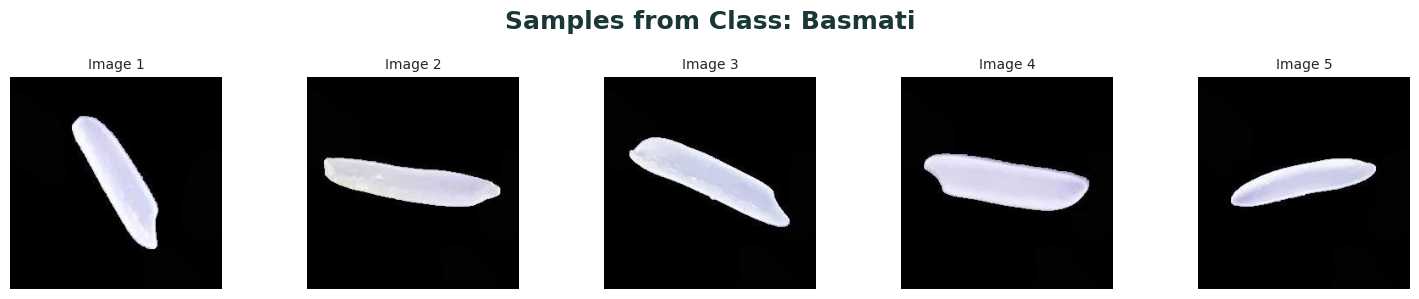

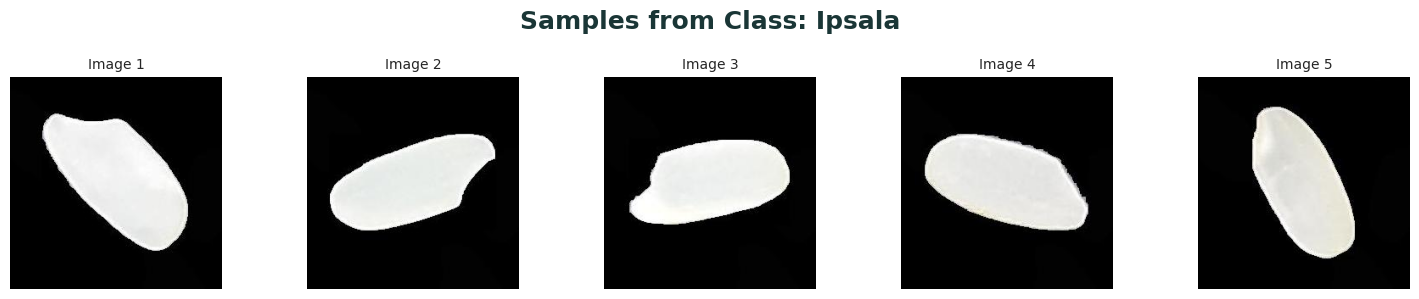

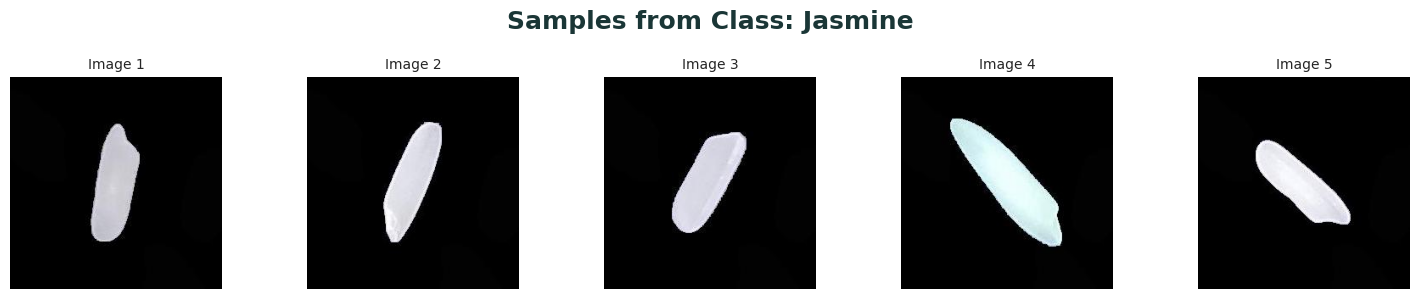

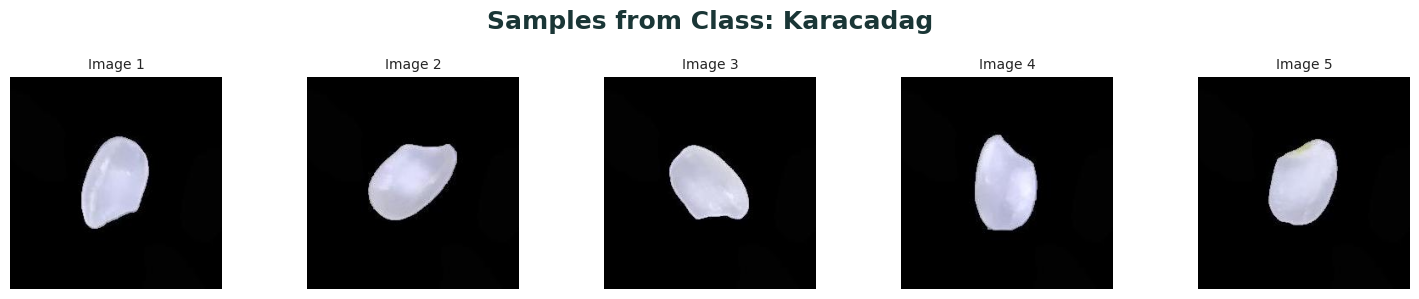

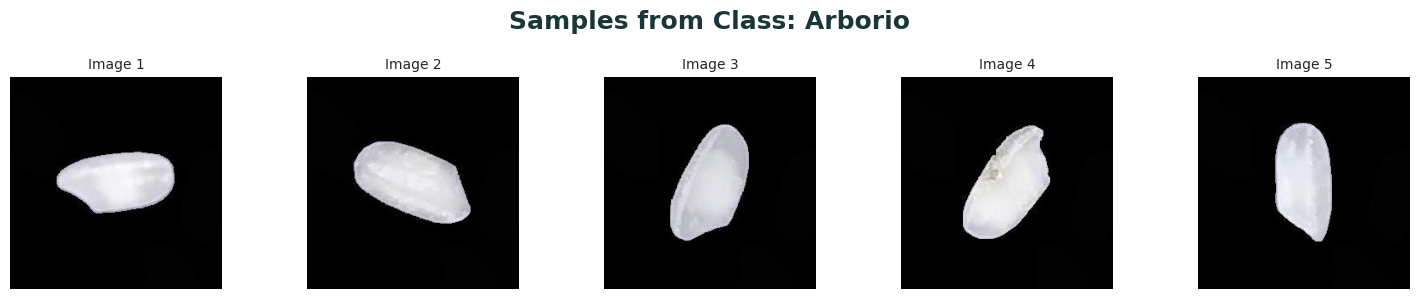

In [ ]:

for class_name in detection:
    # Here I had Prepared class path
    class_path = os.path.join(dir1, class_name)
    # Then Listing images
    images = os.listdir(class_path)
    random_images = random.choices(images, k=5)

    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    plt.suptitle(f'Samples from Class: {class_name}', fontsize=18, fontweight='bold', color='#1A3636')

    for i in range(5):
        # Loaded and displayed the image
        img_path = os.path.join(class_path, random_images[i])
        img = keras.utils.load_img(img_path)
        ax[i].imshow(img)
        ax[i].axis('off')  # Removed axis

        # Its optioonal here we can add image title
        ax[i].set_title(f'Image {i + 1}', fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
# Created a list of tuples that contain image paths and their class labels
image_data = []  # Initialize an empty list for storing image paths and labels

# Iterated through each class in the detection
for class_name in detection:
    class_path = os.path.join(dir1, class_name)  # Create the path for the class
    files = os.listdir(class_path)  # List all files in the class folder

    # Looping through all files and add their paths and class labels to the image_data list
    for file in files:
        file_path = os.path.join(class_path, file)  # Created the full file path
        image_data.append((file_path, class_name))  # Appended tuple to the list

# Converted the list to a pandas DataFrame
df = pd.DataFrame(image_data, columns=['path', 'label'])

# Shuffle the DataFrame rows for randomness
df = df.sample(frac=1).reset_index(drop=True)

display(df.head())

,path,label
0,/root/.cache/kagglehub/datasets/muratkokludata...,Karacadag
1,/root/.cache/kagglehub/datasets/muratkokludata...,Karacadag
2,/root/.cache/kagglehub/datasets/muratkokludata...,Basmati
3,/root/.cache/kagglehub/datasets/muratkokludata...,Karacadag
4,/root/.cache/kagglehub/datasets/muratkokludata...,Arborio


In [ ]:
total_samples = len(df)
print(colored(f'Total number of samples: {total_samples}', 'green', attrs=['underline']))

training_data = df[:60000]
validation_data = df[60000:67500]
test_data = df[67500:]

training_data.reset_index(inplace=True, drop=True)
validation_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

print(colored(f'Number of samples in Training df: {len(training_data)}', attrs=['bold']))
print(colored(f'Number of samples in Validation df: {len(validation_data)}', attrs=['bold']))
print(colored(f'Number of samples in Test df: {len(test_data)}', attrs=['bold']))

Total number of samples: 75000
Number of samples in Training df: 60000
Number of samples in Validation df: 7500
Number of samples in Test df: 7500


### **Image Preprocessing**

In [ ]:
# Setting image dimensions and batch size
IMAGE_SIZE = (224, 224)    #This sets the target size for images.
BATCH_SIZE = 16            #Defined samples per batch

# Initialize the ImageDataGenerator for image normalization
data_gen = ImageDataGenerator(rescale=1.0/255)

def create_data_generator(dataframe, is_training=False):
    return data_gen.flow_from_dataframe(
        dataframe,
        x_col='path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=is_training)

# Here I had  created generators for training, validation and test datasets
train_generator = create_data_generator(training_data, is_training=True)
valid_generator = create_data_generator(validation_data, is_training=False)
test_generator = create_data_generator(test_data, is_training=False)

# input shape of the model
input_shape = (224, 224, 3)

# Building the custom CNN model
model = Sequential()

# Convolutional and MaxPooling layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))  # Convolutional layer with 32 filters of size 3x3
model.add(BatchNormalization())  # Normalizes the output of the previous layer
model.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling layer to reduce dimensions

model.add(Conv2D(64, (3, 3), activation='relu'))  # Another convolutional layer with 64 filters
model.add(BatchNormalization())  # Normalize again
model.add(MaxPooling2D(pool_size=(2, 2)))  # Another max pooling layer

# Flatten the output and add Dense layers
model.add(Flatten())  # Converts the 2D matrix to a 1D vector
model.add(Dense(512, activation='relu'))  # Fully connected layer with 512 units
model.add(Dropout(0.5))  # Dropout layer for regularization
model.add(Dense(64, activation='relu'))  # Another dense layer with 64 units
model.add(Dropout(0.5))  # Another dropout layer
model.add(Dense(len(training_data['label'].unique()), activation='softmax'))  # Output layer for the number of classes

# Compiled the model
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(learning_rate=0.01), metrics=['accuracy'])

model.summary()

print("Custom CNN model is built and ready for training!")

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      95,552,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,604,933 (364.70 MB)

 Trainable params: 95,604,741 (364.70 MB)

 Non-trainable params: 192 (768.00 B)

Custom CNN model is built and ready for training!


### **Saving the best model during training**

In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint('BestModel.keras', save_best_only=True)

# ReduceLROnPlateau Callback to decrease the learning rate based on the 'monitor' parameter after a specified 'patience' period if no improvement is observed
reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Model Training
numepochs = 10

# Starting the timer
start_time = time.time()

history = model.fit(train_generator, epochs=numepochs, validation_data=test_generator,
                    callbacks=[checkpoint_callback, reduce_learning_rate])

# Stopping the timer
end_time = time.time()

# Here we get total training time
training_time = end_time - start_time
print(f"\nTotal training time: {training_time:.2f} seconds")

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 204s 52ms/step - accuracy: 0.7953 - loss: 0.5911 - val_accuracy: 0.9916 - val_loss: 0.0298 - learning_rate: 0.0100
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 184s 49ms/step - accuracy: 0.9665 - loss: 0.1102 - val_accuracy: 0.9935 - val_loss: 0.0276 - learning_rate: 0.0100
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 188s 45ms/step - accuracy: 0.9758 - loss: 0.0898 - val_accuracy: 0.9923 - val_loss: 0.0310 - learning_rate: 0.0100
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 185s 49ms/step - accuracy: 0.9779 - loss: 0.0869 - val_accuracy: 0.9945 - val_loss: 0.0265 - learning_rate: 0.0100
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 184s 45ms/step - accuracy: 0.9809 - loss: 0.0778 - val_accuracy: 0.9944 - val_loss: 0.0302 - learning_rate: 0.0100
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 202s 45ms/step - accuracy: 0.9819 - loss: 0.0732 - val_accuracy: 0.9940 - val_loss: 0.0270 - learning_rate: 0.0100
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 203s 45ms/step -

+----+------------+-----------+----------------+------------+-----------------+
|    |   accuracy |      loss |   val_accuracy |   val_loss |   learning_rate |
|----+------------+-----------+----------------+------------+-----------------|
|  0 |   0.892533 | 0.307374  |       0.9916   |  0.0298147 |           0.01  |
|  1 |   0.968683 | 0.104922  |       0.993467 |  0.027635  |           0.01  |
|  2 |   0.976617 | 0.0856874 |       0.992267 |  0.0310026 |           0.01  |
|  3 |   0.978567 | 0.0831782 |       0.994533 |  0.0265073 |           0.01  |
|  4 |   0.981467 | 0.0746742 |       0.9944   |  0.030221  |           0.01  |
|  5 |   0.982867 | 0.0680184 |       0.994    |  0.0269679 |           0.01  |
|  6 |   0.983083 | 0.0718286 |       0.994667 |  0.027919  |           0.01  |
|  7 |   0.9861   | 0.0593182 |       0.993733 |  0.0267546 |           0.005 |
|  8 |   0.9866   | 0.0565505 |       0.993733 |  0.0277727 |           0.005 |
|  9 |   0.987717 | 0.0544706 |       0.

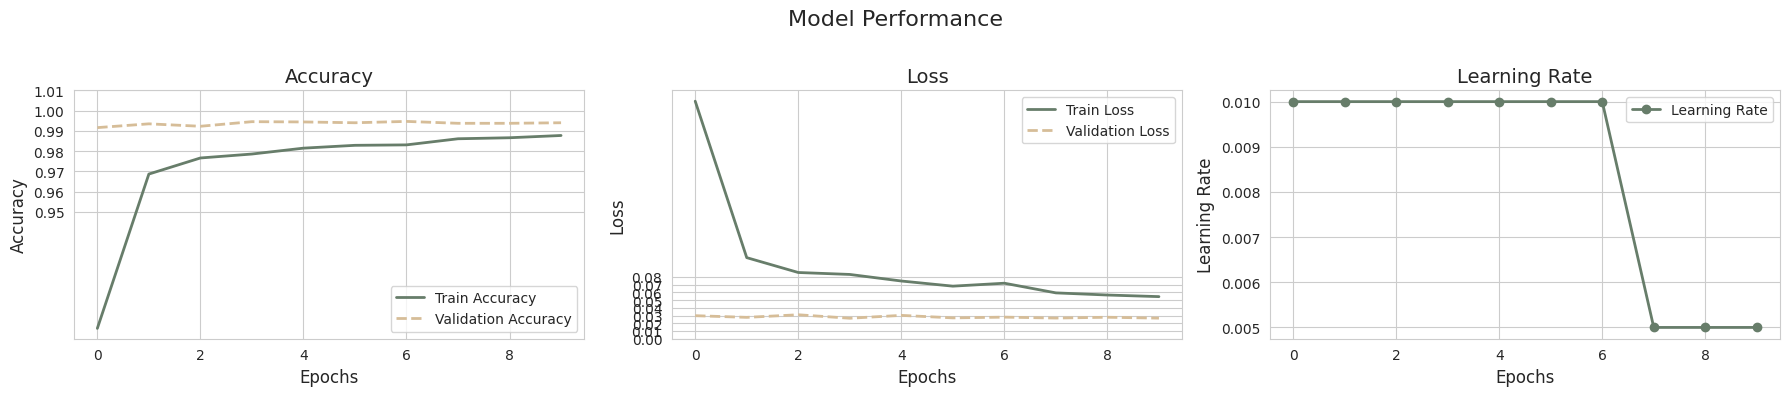

In [ ]:
result_df = pd.DataFrame(history.history)
print(tabulate(result_df, headers='keys', tablefmt='psql'))

# Storing range of epochs
x = np.arange(len(result_df))

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle('Model Performance', fontsize=16)

# ax[0] ---> Accuracy
ax[0].plot(x, result_df.accuracy, label='Train Accuracy', linewidth=2, color='#677D6A')
ax[0].plot(x, result_df.val_accuracy, label='Validation Accuracy', linewidth=2, linestyle='--', color='#D6BD98')
ax[0].set_title('Accuracy', fontsize=14)
ax[0].set_yticks(np.arange(0.95, 1.01, 0.01))
ax[0].set_xticks(np.arange(0, len(result_df), 2))
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].legend()
ax[0].grid(True)

# ax[1] ---> Loss
ax[1].plot(x, result_df.loss, label='Train Loss', linewidth=2, color='#677D6A')
ax[1].plot(x, result_df.val_loss, label='Validation Loss', linewidth=2, linestyle='--', color='#D6BD98')
ax[1].set_title('Loss', fontsize=14)
ax[1].set_xticks(np.arange(0, len(result_df), 2))
ax[1].set_yticks(np.arange(0, 0.085, 0.01))
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].legend()
ax[1].grid(True)

# ax[2] ---> Learning Rate
ax[2].plot(x, result_df.learning_rate, label='Learning Rate', linewidth=2, marker='o', color='#677D6A')
ax[2].set_title('Learning Rate', fontsize=14)
ax[2].set_xticks(np.arange(0, len(result_df), 2))
ax[2].set_xlabel('Epochs', fontsize=12)
ax[2].set_ylabel('Learning Rate', fontsize=12)
ax[2].legend()
ax[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


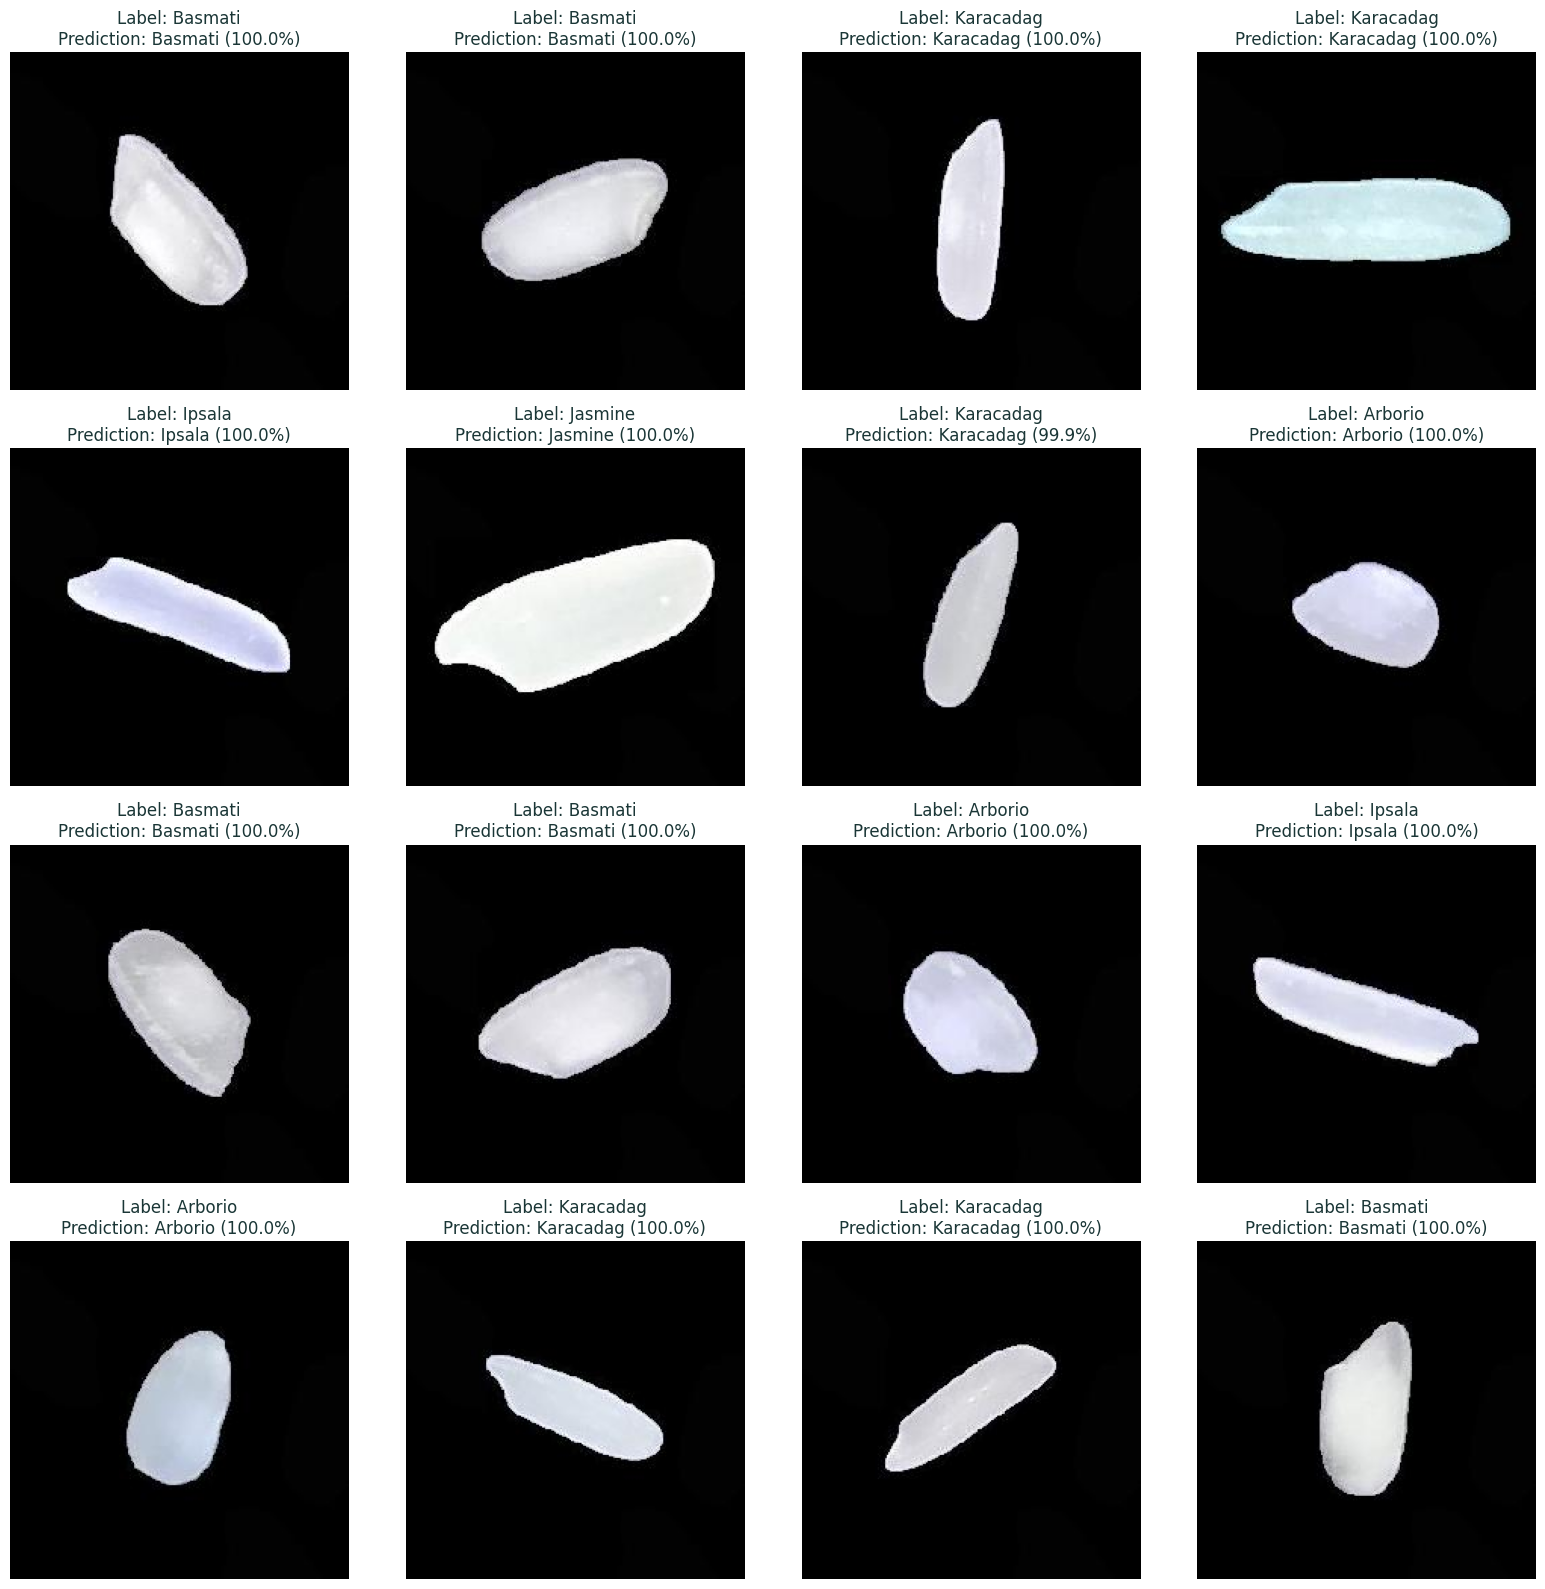

In [ ]:
# I had reset the test data generator to start from the beginning.
test_generator.reset()

# Getting the next batch of images and their corresponding labels from the test generator.
img, label = next(test_generator)

# Generating predictions for the batch of images using the trained model.
predictions = model.predict(img)

# Extracting the predicted classes from the model's output.
test_pred_classes = np.argmax(predictions, axis=1)

plt.figure(figsize=[16, 16])

# Looping through the first 16 images in the batch to display them along with their labels and predictions.
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i])
    plt.axis('off')  # Hiding the axes for a cleaner look

    # Title with the true label, predicted class, and prediction confidence percentage
    plt.title(f"Label: {detection[np.argmax(label[i])]}\n"
              f"Prediction: {detection[test_pred_classes[i]]} "
              f"({100 * np.max(predictions[i]):.1f}%)",
              fontsize=12, color='#1A3636')

plt.tight_layout()
plt.show()

Detailed Classification Report

In [ ]:
# Generated predictions on the test set
print("Generating predictions on the test set...")
y_pred = model.predict(test_generator, verbose=1)

# Converted predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Generated a classification report
print("\nClassification Report:")
clf = classification_report(test_generator.classes, y_pred_classes, target_names=detection)

print("="*50)
print("Detailed Classification Report")
print("="*50)
print(clf)
print("="*50)

Generating predictions on the test set...
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step

Classification Report:
Detailed Classification Report
              precision    recall  f1-score   support

     Basmati       0.99      0.99      0.99      1491
      Ipsala       0.99      0.99      0.99      1517
     Jasmine       1.00      1.00      1.00      1486
   Karacadag       0.99      0.99      0.99      1482
     Arborio       0.99      0.99      0.99      1524

    accuracy                           0.99      7500
   macro avg       0.99      0.99      0.99      7500
weighted avg       0.99      0.99      0.99      7500



### **Confusion Matrix**

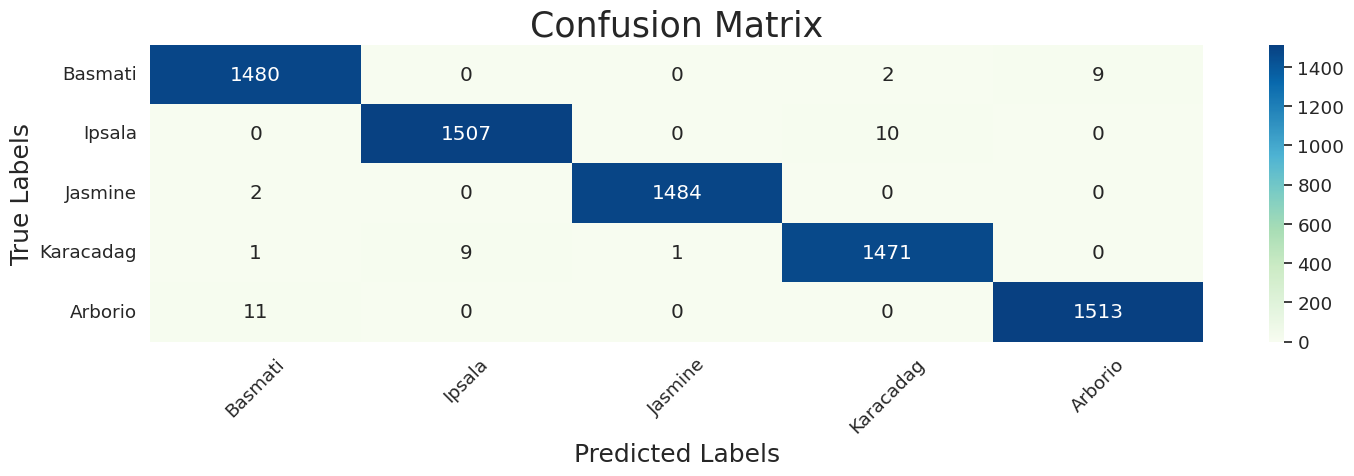

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    """Plot the confusion matrix for the classification results."""
    # Calculating confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(15, 5))
    sns.set(font_scale=1.2)

    # Created heatmap for the confusion matrix
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap="GnBu", cbar=True)

    # Setting labels and title
    ax.set_xlabel('Predicted Labels', fontsize=18)
    ax.set_ylabel('True Labels', fontsize=18)
    ax.set_title('Confusion Matrix', fontsize=25)

    ax.xaxis.set_ticklabels(detection, rotation=45)
    ax.yaxis.set_ticklabels(detection, rotation=0)

    plt.tight_layout()
    plt.show()

plot_confusion_matrix(test_generator.classes, y_pred_classes)